In [1]:
import pystac

import fsspec
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

collection_url = 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/stac/collection.json'  # CDR Stac Collection

In [2]:
collection = pystac.Collection.from_file(collection_url)

We can see the STAC items contained in the collection using the `get_all_items` method. 

In [3]:
items = list(collection.get_all_items())
items

[<Item id=seaice_conc_daily_nh_2024_v04r00>,
 <Item id=seaice_conc_daily_sh_2024_v04r00>,
 <Item id=seaice_conc_monthly_nh_197811_202406_v04r00>,
 <Item id=seaice_conc_monthly_sh_197811_202406_v04r00>,
 <Item id=seaice_conc_daily_sh_2023_v04r00>,
 <Item id=seaice_conc_daily_sh_2022_v04r00>,
 <Item id=seaice_conc_daily_sh_2021_v04r00>,
 <Item id=seaice_conc_daily_sh_2020_v04r00>,
 <Item id=seaice_conc_daily_sh_2019_v04r00>,
 <Item id=seaice_conc_daily_sh_2018_v04r00>,
 <Item id=seaice_conc_daily_sh_2017_v04r00>,
 <Item id=seaice_conc_daily_sh_2016_v04r00>,
 <Item id=seaice_conc_daily_sh_2015_v04r00>,
 <Item id=seaice_conc_daily_sh_2014_v04r00>,
 <Item id=seaice_conc_daily_sh_2013_v04r00>,
 <Item id=seaice_conc_daily_sh_2012_v04r00>,
 <Item id=seaice_conc_daily_sh_2011_v04r00>,
 <Item id=seaice_conc_daily_sh_2010_v04r00>,
 <Item id=seaice_conc_daily_sh_2009_v04r00>,
 <Item id=seaice_conc_daily_sh_2008_v04r00>,
 <Item id=seaice_conc_daily_sh_2005_v04r00>,
 <Item id=seaice_conc_daily_sh_20

We want to plot the daily sea ice concentration in the southern hemispehere for 21 February 2023.  We can do this by finding the STAC item id that meets this criteria.

We could also search for ids that contain "daily", "sh" and "2023"

```
import re

item = [re.search(r"daily_sh_2023", i) for i in items]

item[0].id

'seaice_conc_daily_sh_2023_v04r00'
```

In [4]:
item = collection.get_item("seaice_conc_daily_sh_2023_v04r00")

In [5]:
url = item.assets["netcdf"].href

In [6]:
%%time
fs = fsspec.filesystem("https")
files = fs.open(url)
ds = xr.open_dataset(files, decode_coords="all", chunks={})
ds

CPU times: user 779 ms, sys: 176 ms, total: 954 ms
Wall time: 9.33 s


<xarray.Dataset> Size: 1GB
Dimensions:                      (tdim: 365, y: 332, x: 316)
Coordinates:
    projection                   |S1 1B ...
    time                         (tdim) datetime64[ns] 3kB dask.array<chunksize=(365,), meta=np.ndarray>
    xgrid                        (x) float32 1kB dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                        (y) float32 1kB dask.array<chunksize=(332,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (y, x) float32 420kB dask.array<chunksize=(332, 316), meta=np.ndarray>
    longitude                    (y, x) float32 420kB dask.array<chunksize=(332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-09-26T20:17:19Z
    time_coverage_start:       2023-01-01T00:00:00Z
    time_coverage_end:         2023-12-31T23:59:59Z

The files are not strictly CF-compliant and cannot fully utilize the capabilities of xarray and rioxarray.  To fix this we change the names of the spatial coordinates to match the spatial dimensions, and change the name of the time dimension from `tdim` to `time`.  This way coordinate and dimension names match.

See CF-Conventions

In [7]:
ds = ds.rename_vars({"xgrid": "x", "ygrid": "y"})
ds = ds.swap_dims({"tdim": "time"})
ds

<xarray.Dataset> Size: 1GB
Dimensions:                      (time: 365, y: 332, x: 316)
Coordinates:
    projection                   |S1 1B ...
  * time                         (time) datetime64[ns] 3kB 2023-01-01 ... 202...
  * x                            (x) float32 1kB -3.938e+06 ... 3.938e+06
  * y                            (y) float32 1kB 4.338e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc              (time, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (time, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (time, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    qa_of_cdr_seaice_conc        (time, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (time, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (time, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (time, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (y, x) float32 420kB dask.array<chunksize=(332, 316), meta=np.ndarray>
    longitude                    (y, x) float32 420kB dask.array<chunksize=(332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-09-26T20:17:19Z
    time_coverage_start:       2023-01-01T00:00:00Z
    time_coverage_end:         2023-12-31T23:59:59Z

The `cdr_seaice_conc` variable contains flag values indicating land, coastline and missing data at the pole - known as the pole hole.  The pole hole occures because the satellite has an orbital inclination of 80 degree and does not see the region around the poles. For plotting we want to remove these flag values.  

From the attributes for `cdr_seaice_conc` (click on the file icon next to the variable above), we can see that flag values are 251, 252, 253, 254 and 255.  We can also see that the valid range is 0 to 100.  Actially, because the data are decoded and scaled by 0.001, this information is incorrect and the flag values are 2.51, 2.52, 2.53 and 2.54.  The valid range is 0 to 1.  We can mask out the flags using the `where` method to set data outside the valid range to NaN (not-a-number).

:::{note}
The `where` method retains the DataArray values that satisfy the conditional `ds.cdr_seaice_conc <= 1.`, and by default sets everything else to NaN.
:::

In [8]:
ds["cdr_seaice_conc"] = ds.cdr_seaice_conc.where(ds.cdr_seaice_conc <= 1.)

For most calculations of sea ice area and extent, as well as vizualization, sea ice concentrations less than 0.15 are set to 0.  Concentrations are generally what is known as the marginal ice zone, a region of small broken ice floes that is impacted by waves.  Determining ice concentration in this zone is difficult and estimates of ice concentration uncertain.

We can use a similar method to that used for the flag values to set grid-cells with concentration less than 0.15 to 0.

:::{note}
In this case, the conditional passed to `where` retains values that greater than or equal to 0.15 (`ds.cdr_seaice_conc >= .15`), or that have already been set to NaN (`ds.cdr_seaice_conc.isnull()`).  The `isnull` method checks for NaN.  Rather than using the default replacement value, we set everything else to 0.
:::

In [9]:
ds["cdr_seaice_conc"] = ds.cdr_seaice_conc.where((ds.cdr_seaice_conc >= .15) | 
                                                 (ds.cdr_seaice_conc.isnull()), 0)
# ds["cdr_seaice_conc"] = ds.cdr_seaice_conc.where((ds.cdr_seaice_conc >= .15))

We can now plot the sea ice concentration for the southern hemisphere for 2 February 2023 on a map.  We use `cartopy` and `matplotlib` to do this.

The data are in a projected coordinate system; the NSIDC Polar Stereographic South.  To plot the data correctly on a map and add coastlines, land and other features, we need to define the Coordinate Reference System (CRS).  All the information we need to do this is in the `projection` variable attributes.  

First, we need to define a globe because NSIDC Polar Stereographic CRS use the Hughs 1980 ellipsoid rather than the WGS84 ellipsoid, which is the default ellipsoid for `cartopy` CRS.  This globe is then passed to `cartopy.crs.Stereographic` which is the projection method for NSIDC Polar Stereographic South (and North) CRS.  There are other methods to define the CRS but this is the most transparent way of doing it.

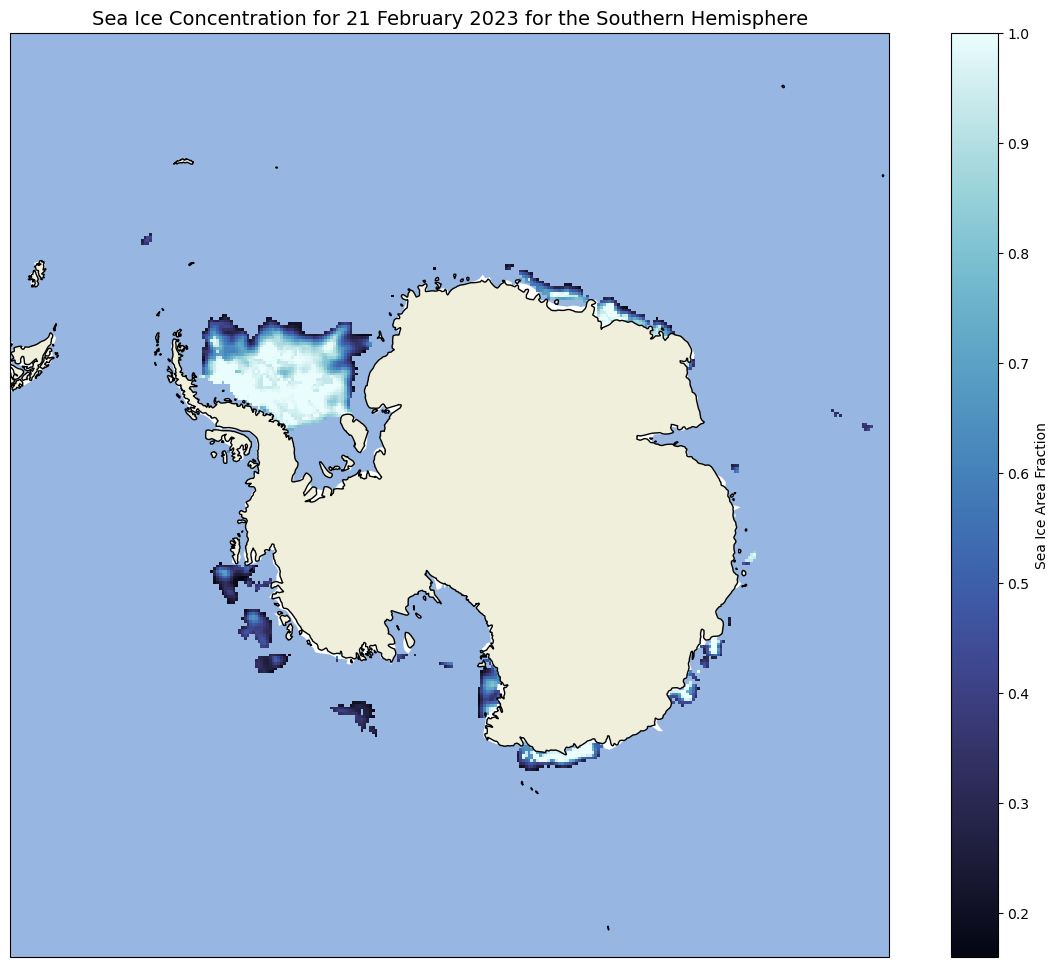

In [13]:
# take projection params from grid mapping variable
globe = ccrs.Globe(
    semimajor_axis=ds.projection.attrs["semimajor_radius"],
    semiminor_axis=ds.projection.attrs["semiminor_radius"],
)
projection = ccrs.Stereographic(
    central_latitude=ds.projection.attrs["latitude_of_projection_origin"], 
    central_longitude=ds.projection.attrs["longitude_of_projection_origin"],
    true_scale_latitude=ds.projection.attrs["standard_parallel"], 
    globe=globe
)

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', 
                                         edgecolor='k', facecolor=cfeature.COLORS['land'])
                                        
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(projection=projection)
ax.add_feature(cfeature.OCEAN)
#ax.stock_img()
ax.add_feature(coastline)
ds.cdr_seaice_conc.sel(time="20230221").plot.pcolormesh(ax=ax, cmap=cmocean.cm.ice, 
                                                        cbar_kwargs={"label": "Sea Ice Area Fraction"})

ax.set_title("Sea Ice Concentration for 21 February 2023 for the Southern Hemisphere", fontsize=14);